- For our positive controls, ideally we’d like to establish a reference ORF paired with two mutants, one showing strong shifts and one subtle in the protein channel as well as detectable changes in morphology. In this case, profiling would especially be helpful. For the NegCons, we must slim down our selection to only 4 ORFs – I’m not sure if you guys have preference for selection there.


- Regarding the PosCons, we’d like to select either IMPDH1 or ALK as our reference allele, 
  plus two of their respective variants (one which shows strong morphological shifts/localization patterns,
  and one that’s subtle). For NegCons, we can only select 4 to include in our screen – 
  I’ll leave it up to you guys which 4 best suit your needs.


- You can disregard all wells that are not labelled either PosCon or NegCon for this screen. 
  And please keep in mind each quadrant received a varying dose of viral supernatant. 
  The amount I settled on for our final pipeline is 6 uL, so perhaps you want to pay attention to the wells which     received a vTitre = 6.


In [174]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import sklearn.preprocessing as sp
import pickle
# from imblearn.over_sampling import SMOTE  
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import os

from scipy.stats import pearsonr
import scipy
from matplotlib import rcParams
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, '/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/') 
from singlecell.preprocess import handle_nans, extract_cpfeature_names

import sys
sys.path.insert(0, '/home/ubuntu/workspace_rare/2017_09_27_RareDiseases_Taipale/') 
from utils import preprocessing,meanProfileAnalysis,visualization,impactscore
from datetime import date
today = date.today()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read cleaned metadata from "metadata/reprocessed" folder

In [175]:
# rootDir='/home/ubuntu/bucket/projects/2017_10_19_Profiling_rare_ORFs/workspace/'
rootDir='/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace/'
# batch='2022_08_22_Batch_1'
batch='2023_02_23_Batch_3'
annot_df=pd.read_csv(rootDir+'/metadata/reprocessed/'+batch+'.csv')
annot_df.head()

Metadata_Well 384_ID            entryID Symbol  entry_plate.x entry_well.x  \
0           A01    1_1    DisWTGDEh03_F06  ACSF3    DisWTGDEh03          F06   
1           C01    3_1  VUSmut_GDEh03_A02  ACSF3  VUSmut_GDEh03          A02   
2           E01    5_1  VUSmut_GDEh03_A03  ACSF3  VUSmut_GDEh03          A03   
3           G01    7_1  VUSmut_GDEh03_B02  ACSF3  VUSmut_GDEh03          B02   
4           I01    9_1  VUSmut_GDEh03_B03  ACSF3  VUSmut_GDEh03          B03   

   entry_numb  dest_plate_96 dest_well_96  dest_numb_96  ...  r384 c384  \
0        46.0  FVrry_P01_Q01          A01           1.0  ...   1.0  1.0   
1         9.0  FVrry_P01_Q01          B01           2.0  ...   3.0  1.0   
2        17.0  FVrry_P01_Q01          C01           3.0  ...   5.0  1.0   
3        10.0  FVrry_P01_Q01          D01           4.0  ...   7.0  1.0   
4        18.0  FVrry_P01_Q01          E01           5.0  ...   9.0  1.0   

       Metadata_Plate               batch control   Gene         MT  \
0  2022_10_11_PPL9_P1  2023_02_23_Batch_3   False  ACSF3        NaN   
1  2022_10_11_PPL9_P1  2023_02_23_Batch_3   False  ACSF3  Ala197Thr   
2  2022_10_11_PPL9_P1  2023_02_23_Batch_3   False  ACSF3  Thr358Ile   
3  2022_10_11_PPL9_P1  2023_02_23_Batch_3   False  ACSF3  Met198Arg   
4  2022_10_11_PPL9_P1  2023_02_23_Batch_3   False  ACSF3  Glu359Lys   

           Variant  Metadata_Sample_Unique  \
0            ACSF3                   ACSF3   
1  ACSF3 Ala197Thr         ACSF3 Ala197Thr   
2  ACSF3 Thr358Ile         ACSF3 Thr358Ile   
3  ACSF3 Met198Arg         ACSF3 Met198Arg   
4  ACSF3 Glu359Lys         ACSF3 Glu359Lys   

                    Metadata_batch_Plate  
0  2023_02_23_Batch_3-2022_10_11_PPL9_P1  
1  2023_02_23_Batch_3-2022_10_11_PPL9_P1  
2  2023_02_23_Batch_3-2022_10_11_PPL9_P1  
3  2023_02_23_Batch_3-2022_10_11_PPL9_P1  
4  2023_02_23_Batch_3-2022_10_11_PPL9_P1  

[5 rows x 32 columns]

In [207]:
# annot_df['Gene'].unique()

In [185]:
def read_per_well_data_csvs(input_data_dir,annot,profile_type):
    batches=annot['batch'].unique()
    
    df_agg_all_batches_ls=[]
    for b in batches:
        print(b)
        df_sag_ls=[]
        plates_exist=os.listdir(input_data_dir+'/profiles/'+b)
        plates_meta=annot.loc[annot['batch']==b,'Metadata_Plate'].unique()
        plates=set(plates_meta) & set(plates_exist)
#         print(plates_meta, plates_exist)
        for p in plates:
            print(p)
            
            fileName=input_data_dir+'/profiles/'+b+'/'+p+'/'+p+''+profile_type+'.csv.gz'
            print(fileName)
            if os.path.exists(fileName):
                sc_df=pd.read_csv(fileName,compression='gzip')

        #         per_site_aggregate=sc_df.groupby(['Metadata_Well','Metadata_Site']).mean()[feature_list+['Count_Cells']].reset_index()
                sc_df['Metadata_Batch']=b
                sc_df['Metadata_Plate']=p
                df_sag_ls.append(sc_df)
                del sc_df
#                 gc.collect()
            else:
                print(fileName,' not exists')

        if df_sag_ls:
            df_sag=pd.concat(df_sag_ls,axis=0)
            df_agg_all_batches_ls.append(df_sag)

    df_agg_all_batches=pd.concat(df_agg_all_batches_ls,axis=0)
    return df_agg_all_batches

In [78]:
# profiles_path = '/home/ubuntu/bucket/projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace'


In [81]:
# df_agg_all_batches['Metadata_Plate']

#### 5. Load and preprocess replicate level profiles

In [186]:
profile_type = '_normalized_feature_select_batch'
df_agg_all_batches=read_per_well_data_csvs(rootDir,annot_df,profile_type);

prot_ch_suffix='GFP'

cp_features, cp_features_analysis = extract_cpfeature_names.extract_cpfeature_names(df_agg_all_batches);
#   df_batch_plates, cp_features_analysis_batch = handle_nans.handle_nans(df,cp_features_analysis,\
#                                                    thrsh_null_ratio=0.05,fill_na_method='drop-rows');  

df_batch_plates, cp_features_analysis_batch = handle_nans.handle_nans(df_agg_all_batches,cp_features_analysis,\
                                               thrsh_null_ratio=0);  

cpFeats_P=[p for p in cp_features_analysis_batch if prot_ch_suffix in p]
cpFeats_NP=[p for p in cp_features_analysis_batch if (prot_ch_suffix not in p)]
print(len(cpFeats_P),len(cpFeats_NP))

cols_to_use = annot_df.columns.difference(df_batch_plates.columns).tolist()
df_batch_plates_annot=pd.merge(df_batch_plates, annot_df[cols_to_use+['Metadata_Plate','Metadata_Well']],\
                                 how='inner',on=['Metadata_Plate','Metadata_Well']);

# df_scaled_annot,cpFeats_A,cpFeats_P,cpFeats_NP=\
# meanProfileAnalysis.read_merge_preprocess_meanProfiles(annot_df,read_pop_params);

# # dfTransSummary = df_scaled_annot[['Metadata_batch_Plate','Metadata_Sample_Unique','n_transf','n_untransf','transf_Ratio']]
# dfTransSummary=df_scaled_annot[annot_df.columns.tolist()+['n_transf','n_untransf','transf_Ratio']];


2023_02_23_Batch_3
2022_10_11_PPL9_P1
/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace//profiles/2023_02_23_Batch_3/2022_10_11_PPL9_P1/2022_10_11_PPL9_P1_normalized_feature_select_batch.csv.gz
2022_09_29_PPL9_P2
/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace//profiles/2023_02_23_Batch_3/2022_09_29_PPL9_P2/2022_09_29_PPL9_P2_normalized_feature_select_batch.csv.gz
2022_09_29_PPL9_P3
/home/ubuntu/bucket/projects/2021_09_01_VarCHAMP/workspace//profiles/2023_02_23_Batch_3/2022_09_29_PPL9_P3/2022_09_29_PPL9_P3_normalized_feature_select_batch.csv.gz
cp_features: 680
cols2remove_manyNulls ['Cells_Neighbors_AngleBetweenNeighbors_30']
cols2remove_lowVars []
len cp_features_analysis/nan cols/low vars: 679 1 0
95 584


In [243]:
# df_batch_plates['batch']
# print(cols_to_use)

In [241]:
# df_batch_plates_annot['Metadata_batch_Plate']
# df_batch_plates_annot[df_batch_plates_annot['Metadata_Sample_Unique']=='516 - TC ']

In [242]:
# df_batch_plates_annot[df_batch_plates_annot['Metadata_Sample_Unique']!='516 - TC'].reset_index(drop=True)

#### 6. Calculate replicate correlation of profiles
Save curve plots and values to results/replicate_corr_curves

p Protein_Channel


<IPython.core.display.Javascript object>


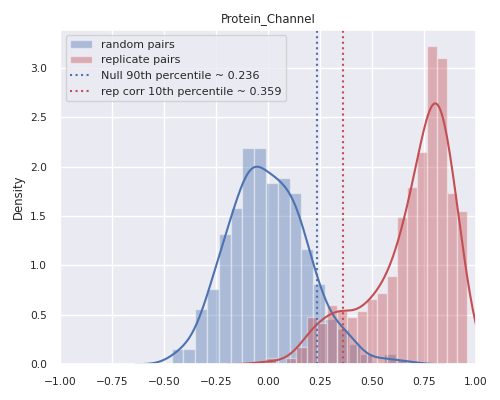

/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:96: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:105: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

np NonProtein_Channels


<IPython.core.display.Javascript object>


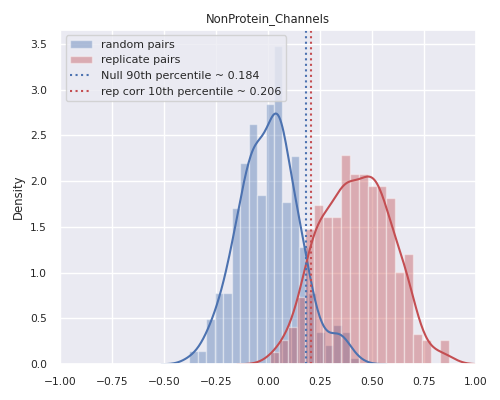

/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:96: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/process/replicate_correlation.py:105: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6

In [189]:
from singlecell.process.replicate_correlation import replicate_null_corr_coefs
from singlecell.process import normalize_funcs

scal_status='standardized_perPlate'


df_rep_level=df_batch_plates_annot[df_batch_plates_annot['Metadata_Sample_Unique']!='516 - TC'].reset_index(drop=True)

if scal_status=='standardized_perPlate':
    df_rep_level_scaled=normalize_funcs.standardize_per_catX(df_rep_level,'Metadata_Plate',cpFeats_P+cpFeats_NP).copy();
# df_rep_level_scaled = normalize_funcs.standardize_df_columns(df_rep_level,cpFeats_P+cpFeats_NP,'Standard')
else:
    df_rep_level_scaled = df_rep_level.copy()
    
    
    
nOfReps=df_rep_level_scaled.groupby(['Metadata_Sample_Unique']).size().reset_index()
pairWithReplicates=nOfReps.loc[nOfReps[0]!=1,:].reset_index()['Metadata_Sample_Unique']#.groupby([0]).size()

# scal_status=df_rep_level_scaled['normalization'].unique()[0]
# zscor_status=df_rep_level_scaled['zscored'].unique().astype(str)[0]
# zscor_status='nan'
# if not np.isnan(df_rep_level_scaled['zscored'].unique()[0])

saveDir=rootDir+'/results/replicate_corr_curves/'+batch
# 
os.makedirs(saveDir, exist_ok=True)

pertColName='Metadata_Sample_Unique'
repCor4impactList=[]
for f,ch,t in zip([cpFeats_P,cpFeats_NP],['p','np'],['Protein_Channel','NonProtein_Channels']):
    print(ch,t)
#     t2=t+', '+scal_status+', zscored: '+zscor_status
    fh_2save,repCorrDf=replicate_null_corr_coefs(df_rep_level_scaled,pertColName,f,1,title=t,hist_bins=20)
    fh_2save.savefig(saveDir+'/'+ch+'_'+profile_type+'.png')
    repCorrDf=repCorrDf.add_suffix('_'+ch)
    repCor4impactList.append(repCorrDf);
    
repCorr_df_avg=pd.concat(repCor4impactList,axis=1).reset_index().rename(columns={'index':pertColName})
repCorr_df_avg.to_csv(saveDir+'/'+scal_status+'_'+profile_type+'.csv',index=False)
df_rep_level_scaled=pd.merge(df_rep_level_scaled,repCorr_df_avg,how='left',on=pertColName)

#### 7. Calculate WT-MT impact scores and save
- Approach 1: average replicate level profiles and score treatment level profiles
- Approach 2: calculate impact scores per plate

In [240]:
# Approach 1

# df_rep_level_scaled['Gene-dose']=df_rep_level_scaled['Gene']+'-'+df_rep_level_scaled['vTitre'].astype(str)
wt_mt_cols=['Gene','Metadata_Sample_Unique']
impact_scores_trt_profs = impactscore.impact_score_wt_mt(df_rep_level_scaled,repCorr_df_avg,[cpFeats_P,cpFeats_NP],\
                                                        wt_mt_cols);
saveDir=rootDir+'/results/Impact-Scores/Method-MeanProfiles/'+batch
os.makedirs(saveDir, exist_ok=True)
impact_scores_trt_profs.to_csv(saveDir+'/impact_scores_trt_'+today.strftime("%Y%m%d")+'.csv',index=False)

impactfull_ratio_p=impact_scores_trt_profs[impact_scores_trt_profs['cc_p']<impact_scores_trt_profs['Rep10Perc_p']].shape[0]/impact_scores_trt_profs.shape[0]
impactfull_ratio_np=impact_scores_trt_profs[impact_scores_trt_profs['cc_np']<impact_scores_trt_profs['Rep10Perc_np']].shape[0]/impact_scores_trt_profs.shape[0]
print(impactfull_ratio_p, impactfull_ratio_np)

0.39669421487603307 0.40082644628099173


In [237]:
# Approach 2
impact_scores_perplate = impactscore.impact_score_wt_mt_perplate(df_rep_level_scaled,repCorr_df_avg,[cpFeats_P,cpFeats_NP])
impact_scores_perplate[['cc_p','cc_np', 'RepCor_p', 'Rand90Perc_p', 'Rep10Perc_p', 'RepCor_np',\
       'Rand90Perc_np', 'Rep10Perc_np']]=\
        impact_scores_perplate[['cc_p','cc_np', 'RepCor_p', 'Rand90Perc_p', 'Rep10Perc_p', 'RepCor_np',\
       'Rand90Perc_np', 'Rep10Perc_np']].astype('float32')
saveDir=rootDir+'/results/Impact-Scores/Method-MeanProfiles/'+batch
os.makedirs(saveDir, exist_ok=True)
impact_scores_perplate.to_csv(saveDir+'/impact_scores_perplate_'+today.strftime("%Y%m%d")+'.csv',index=False)

# impact_scores_perplate_avg = impact_scores_perplate[['Metadata_Sample_Unique','cc_p','cc_np']].groupby('Metadata_Sample_Unique').mean()
impact_scores_perplate_avg = impact_scores_perplate.groupby('Metadata_Sample_Unique').mean()

impactfull_ratio_p=impact_scores_perplate_avg[impact_scores_perplate_avg['cc_p']<impact_scores_perplate_avg['Rep10Perc_p']].shape[0]/impact_scores_perplate_avg.shape[0]
impactfull_ratio_np=impact_scores_perplate_avg[impact_scores_perplate_avg['cc_np']<impact_scores_perplate_avg['Rep10Perc_np']].shape[0]/impact_scores_perplate_avg.shape[0]
print(impactfull_ratio_p, impactfull_ratio_np)

0.45454545454545453 0.41735537190082644


In [ ]:
print(impact_scores_trt_profs[['Gene','Metadata_Sample_Unique', 'cc_p', 'wt_RepCor_p', 'cc_np',\
       'wt_RepCor_np', 'RepCor_p', 'Rand90Perc_p', 'Rep10Perc_p', 'RepCor_np',\
       'Rand90Perc_np', 'Rep10Perc_np']].to_markdown())